# Distributed Training and Inference with Spark 3.4

Based on: https://docs.databricks.com/machine-learning/train-model/distributed-training/spark-pytorch-distributor.html#end-to-end-distributed-training-on-databricks-notebook

## Setup

In [ ]:
access_key = dbutils.secrets.get(scope="aws-s3", key = "aws-access-key")
secret_key = dbutils.secrets.get(scope="aws-s3", key = "aws-secret-key")
sc._jsc.hadoopConfiguration().set("fs.s3a.access.key", access_key)
sc._jsc.hadoopConfiguration().set("fs.s3a.secret.key", secret_key)

In [ ]:
S3_BUCKET="s3a://path/to/bucket"

### Define Model

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from time import time
from torchvision import datasets, transforms

PYTORCH_DIR = "/dbfs/ml/pytorch"
os.environ["TORCH_HOME"] = PYTORCH_DIR

batch_size = 100
num_epochs = 5
momentum = 0.5
log_interval = 100
learning_rate = 0.001


# Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)


### Define Common Functions

In [ ]:
def prepare_batch(batch):
    # shim to allow transforming the output of the data loader in Advanced section below
    # pass-through by default
    return batch

def train_one_epoch(model, device, data_loader, optimizer, epoch, prepare_batch):
    model.train()
    for batch_idx, batch in enumerate(data_loader):
        data, target = prepare_batch(batch)  # added prepare_batch for advanced data loading
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(
                "Train Epoch: {} [{}]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    loss.item(),
                )
            )


def save_checkpoint(log_dir, model, optimizer, epoch):
    filepath = log_dir + "/checkpoint-{epoch}.pth.tar".format(epoch=epoch)
    state = {
        "model": model.module.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(state, filepath)


def load_checkpoint(log_dir, epoch=num_epochs):
    filepath = log_dir + "/checkpoint-{epoch}.pth.tar".format(epoch=epoch)
    return torch.load(filepath)


def create_log_dir():
    log_dir = os.path.join(PYTORCH_DIR, str(time()))
    os.makedirs(log_dir)
    return log_dir

## Distributed Training

### Main Function

The [conversion steps](https://pytorch.org/tutorials/intermediate/ddp_series_multinode.html) from single-node to distributed are highlighted in comments below.

**Note**: the data loaders have been factored out, so we can swap in different implementations in the "Advanced" section below.

In [ ]:
def main_fn(directory):
    #### Added Torch Distributed imports ####
    import torch.distributed as dist
    from torch.nn.parallel import DistributedDataParallel as DDP

    print("Running distributed training")
    dist.init_process_group("nccl")

    local_rank = int(os.environ["LOCAL_RANK"])
    global_rank = int(os.environ["RANK"])
    world_size = int(os.environ["WORLD_SIZE"])

    #### Adjust batch size per worker ####
    adjusted_batch_size = batch_size // world_size
    print(f"{adjusted_batch_size=}")

    if global_rank == 0:
        train_parameters = {
            "batch_size": adjusted_batch_size,
            "epochs": num_epochs,
            "trainer": "TorchDistributor",
        }

    model = Net().to(local_rank)
    #### Added Distributed Model ####
    ddp_model = DDP(model, device_ids=[local_rank], output_device=local_rank)

    optimizer = optim.SGD(ddp_model.parameters(), lr=learning_rate, momentum=momentum)
    for epoch in range(1, num_epochs + 1):
        # train data_loader
        data_loader = get_train_dataloader(adjusted_batch_size)

        train_one_epoch(ddp_model, local_rank, data_loader, optimizer, epoch, prepare_batch)

        if global_rank == 0:
            save_checkpoint(directory, ddp_model, optimizer, epoch)

    if global_rank == 0:
        ddp_model.eval()

        # test data_loader
        data_loader = get_test_dataloader(batch_size)

        test_loss = 0
        num_batches = 0
        for batch in data_loader:
            data, target = prepare_batch(batch)
            device = torch.device("cuda")
            data, target = data.to(device), target.to(device)
            output = ddp_model(data)
            test_loss += F.nll_loss(output, target)
            num_batches += 1

        test_loss /= num_batches
        print("Average test loss: {}".format(test_loss.item()))

    dist.destroy_process_group()

    return "finished"  # can return any picklable object

### Torch Datasets Data Loader
This example just downloads the MNIST dataset to each worker and then uses the Torch DistributedSampler to shard the data.

**Note**: that this only works if the dataset is small enough to be downloaded to each worker.  For larger datasets, see the "Advanced" section below.

In [ ]:
def get_train_dataloader(batch_size, distributed=True):
    if distributed:
        from torch.utils.data.distributed import DistributedSampler

    train_dataset = datasets.MNIST(
        "data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
        ),
    )
    
    #### Added Distributed Dataloader ####
    train_sampler = DistributedSampler(train_dataset) if distributed else None
    data_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler
    )
    return data_loader

def get_test_dataloader(batch_size):
    test_dataset = datasets.MNIST(
        "data",
        train=False,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
        ),
    )
    data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)  
    return data_loader

### Train with TorchDistributor
See: https://spark.apache.org/docs/latest//api/python/reference/api/pyspark.ml.torch.distributor.TorchDistributor.html

In [ ]:
from pyspark.ml.torch.distributor import TorchDistributor

multi_node_multi_gpu_dir = create_log_dir()
print("Log directory: ", create_log_dir())

# Set num_processes = NUM_WORKERS * NUM_GPUS_PER_WORKER
output_dist = TorchDistributor(num_processes=2, local_mode=False, use_gpu=True).run(main_fn, multi_node_multi_gpu_dir)


Log directory:  /dbfs/ml/pytorch/1683755013.639396


Started distributed training with 2 executor proceses
Running distributed training
Running distributed training
adjusted_batch_size=50
adjusted_batch_size=50
Train Epoch: 1 [0]	Loss: 2.315846
Train Epoch: 1 [0]	Loss: 2.328258
Train Epoch: 1 [5000]	Loss: 2.318942
Train Epoch: 1 [5000]	Loss: 2.305338
Train Epoch: 1 [10000]	Loss: 2.295995
Train Epoch: 1 [10000]	Loss: 2.291051
Train Epoch: 1 [15000]	Loss: 2.282527
Train Epoch: 1 [15000]	Loss: 2.305161
Train Epoch: 1 [20000]	Loss: 2.282576
Train Epoch: 1 [20000]	Loss: 2.280523
Train Epoch: 1 [25000]	Loss: 2.272546
Train Epoch: 1 [25000]	Loss: 2.324517
Train Epoch: 2 [0]	Loss: 2.263000
Train Epoch: 2 [0]	Loss: 2.253219
Train Epoch: 2 [5000]	Loss: 2.269941
Train Epoch: 2 [5000]	Loss: 2.256959
Train Epoch: 2 [10000]	Loss: 2.222101
Train Epoch: 2 [10000]	Loss: 2.250984
Train Epoch: 2 [15000]	Loss: 2.173892
Train Epoch: 2 [15000]	Loss: 2.258744
Train Epoch: 2 [20000]	Loss: 2.161367
Train Epoch: 2 [20000]	Loss: 2.194634
Train Epoch: 2 [25000]	Los

## Distributed Inference

### Convert Test Data to Parquet

To emulate the use case where the dataset resides on a distributed file system, save the dataset as Parquet files to an S3 bucket.

**Note**: this only needs to be run once, so you can skip this section if you've already generated the test dataset on S3.

In [ ]:
import numpy as np
import pandas as pd
from pyspark.sql.types import StructType, StructField, ArrayType, FloatType, LongType

In [ ]:
def save_as_parquet(data_loader, bucket):
    data, labels = next(iter(data_loader))

    # flatten images
    np_data = np.array(data).reshape(-1, 784)

    # create pandas dataframe with single array column
    pdf = pd.DataFrame(np_data)
    pdf1 = pd.DataFrame()
    pdf1['data'] = pdf.values.tolist()
    pdf1['label'] = labels
    
    # convert to Spark DataFrame
    schema = StructType([
        StructField("data",ArrayType(FloatType()), True),
        StructField("label", LongType(), True)
      ])
    df = spark.createDataFrame(pdf1, schema)

    # save DataFrame to S3 bucket as parquet
    df.write.mode("overwrite").parquet(bucket)

In [ ]:
# save test dataset as parquet to S3
test_data_loader = get_test_dataloader(batch_size=10000)
save_as_parquet(test_data_loader, f"{S3_BUCKET}/test")

### Inference with predict_batch_udf
See: https://spark.apache.org/docs/latest//api/python/reference/api/pyspark.ml.functions.predict_batch_udf.html

In [ ]:
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import struct, col, array
from pyspark.sql.types import ArrayType, FloatType, Union, Dict

In [ ]:
df = spark.read.parquet("${S3_BUCKET}/test")

In [ ]:
def predict_batch_fn():
    import torch    
    device = torch.device("cuda")
    model = Net().to(device)
    checkpoint = load_checkpoint(multi_node_multi_gpu_dir)
    model.load_state_dict(checkpoint['model'])

    def predict(inputs):
        torch_inputs = torch.from_numpy(inputs).to(device)
        outputs = model(torch_inputs)
        return outputs.cpu().detach().numpy()
    
    return predict

In [ ]:
mnist = predict_batch_udf(predict_batch_fn,
                          input_tensor_shapes=[[1,28,28]],
                          return_type=ArrayType(FloatType()),
                          batch_size=1000)

In [ ]:
preds = df.withColumn("preds", mnist('data')).collect()

### Check predictions

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

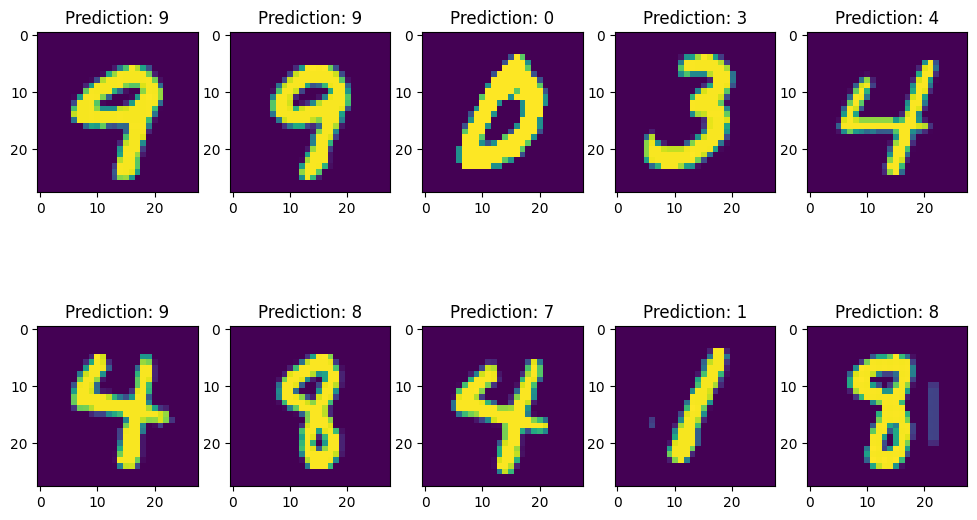

In [ ]:
fig, ax = plt.subplots(2,5)
for i, ax in enumerate(ax.flatten()):
    img = np.array(preds[i].data).reshape(28,28)
    prediction = np.argmax(preds[i].preds)
    ax.set_title(f"Prediction: {prediction}")
    ax.imshow(img)

plt.rcParams["figure.figsize"] = (12,7)
plt.show()

## Advanced
For most real-world use cases with Spark and DL, the training datasets will generally be much larger than can be hosted on a single box. Instead, they will typically be stored in a distributed filesystem, like HDFS, S3, or GCS.  The following code demonstrates how to access a distributed dataset (hosted in S3) during training.

**Note**: For simplicity, we will continue to use the MNIST dataset, but keep in mind that real-world datasets will be several orders of magnitude larger.

### Convert Train Data to Parquet

To emulate the use case where the dataset resides on a distributed file system, save the dataset as Parquet files to an S3 bucket.

**Note**: this only needs to be run once, so you can skip this section if you've already generated the dataset on S3.

In [ ]:
# save train dataset as parquet to S3
train_data_loader = get_train_dataloader(batch_size=60000, distributed=False)
save_as_parquet(train_data_loader, f"{S3_BUCKET}/train")

### Distributed Data Loader
Since the dataset is stored in a distributed filesystem, you will need to use a distributed data loader capable of sharding files across the workers.  Currently, there are two main options (aside from custom data loaders):
- Petastorm
- NVTabular

Since the cluster is already configured with GPUs, we will demonstrate using NVTabular here, since it provides GPU-accelerated data loading with built-in support for S3FS and Parquet files.

In [ ]:
storage_options={"key": access_key, "secret": secret_key}

def seed_fn():
    """
    Generate consistent dataloader shuffle seeds across workers
    Reseeds each worker's dataloader each epoch to get fresh a shuffle
    that's consistent across workers.
    """
    return 0

def get_train_dataloader(batch_size,):
    import nvtabular as nvt
    from nvtabular.loader.torch import TorchAsyncItr, DLDataLoader

    global_rank = int(os.environ["RANK"])
    world_size = int(os.environ["WORLD_SIZE"])

    train_dataset = TorchAsyncItr(
        nvt.Dataset(f"{S3_BUCKET}/train", engine="parquet", storage_options=storage_options),
        batch_size=batch_size,
        cats=[],
        conts=["data"],
        labels=["label"],
        shuffle=True,
        parts_per_chunk=1,
        global_size=world_size,
        global_rank=global_rank,
        seed_fn=seed_fn
    )
    train_loader = DLDataLoader(
        train_dataset, batch_size=None, collate_fn=lambda x: x, pin_memory=False, num_workers=0
    )

    return train_loader


def get_test_dataloader(batch_size):
    import nvtabular as nvt
    from nvtabular.loader.torch import TorchAsyncItr, DLDataLoader

    global_rank = int(os.environ["RANK"])
    world_size = int(os.environ["WORLD_SIZE"])

    train_dataset = TorchAsyncItr(
        nvt.Dataset(f"{S3_BUCKET}/test", engine="parquet", storage_options=storage_options),
        batch_size=batch_size,
        cats=[],
        conts=["data"],
        labels=["label"],
        shuffle=False,
        parts_per_chunk=1,
        global_size=world_size,
        global_rank=global_rank,
        seed_fn=seed_fn
    )
    train_loader = DLDataLoader(
        train_dataset, batch_size=None, collate_fn=lambda x: x, pin_memory=False, num_workers=0
    )

    return train_loader

def prepare_batch(batch):
    data = batch[0]['data__values'].reshape(-1,1,28,28)
    label = batch[1]
    return data, label

### Train with NVTabular Data Loader

In [ ]:
from pyspark.ml.torch.distributor import TorchDistributor

multi_node_multi_gpu_dir = create_log_dir()
print("Log directory: ", create_log_dir())

# Set num_processes = NUM_WORKERS * NUM_GPUS_PER_WORKER
output_dist = TorchDistributor(num_processes=2, local_mode=False, use_gpu=True).run(main_fn, multi_node_multi_gpu_dir)


Log directory:  /dbfs/ml/pytorch/1683755103.642704


Started distributed training with 2 executor proceses
Running distributed training
Running distributed training
adjusted_batch_size=50
adjusted_batch_size=50
2023-05-10 21:45:14.407035: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 21:45:14.551173: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-10 21:45:15.573393: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following